In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import pandas as pd
from ipywidgets import interact

# Binary classification

[toxity dataset](https://online.stat.psu.edu/stat462/node/208/)

In [2]:
n_ind = 250
data = dict(doses=range(1,7),deaths=[28,53,93,126,172,197])
df = pd.DataFrame.from_dict(data)
df['p_dying'] = df['deaths']/n_ind


In [3]:
px.scatter(data_frame=df, x='doses', y='deaths')

# Logistic regression

In [4]:
def sigmoid(x,a,b):
    return 1/(1 + np.exp(-(a*x+b)))

In [5]:
a, b = 0.5, -2

vecd = np.arange(0,7,0.1)

Fig = go.Figure()


Fig.add_scatter(x=df['doses'], y=df['p_dying'], mode='markers', name='toxity dataset')

Fig.add_trace(go.Scatter(name=f'sigmoid: a={a}, b={b}',x=vecd,y=sigmoid(vecd,a,b)))




In [6]:
#| echo: false
def hlines(a,b):
    vecd = np.arange(0,7,0.1)
    Fig = go.FigureWidget()
    Fig.add_scatter(x=df['doses'], y=df['p_dying'], mode='markers')
    Fig.add_trace(
        go.Scatter(
            line=dict(color="#00CED1", width=4),
            name="Sigmoid",
            x=vecd,
            y=sigmoid(vecd,a,b))
        )
    
    Fig.update_yaxes(range=[0, 1])

    Fig.show()

interact(hlines, a=(-5,5,0.1), b=(-5,5,0.1));

interactive(children=(FloatSlider(value=0.0, description='a', max=5.0, min=-5.0), FloatSlider(value=0.0, descr…

# The dataset 

In [7]:
for i, d in zip(df['doses'], df['deaths']):
    vec1 = np.zeros((n_ind,2))
    vec1[:,0], vec1[:d,1] = i, 1
    vec = vec1 if i ==1 else np.concatenate((vec,vec1))
    
np.random.shuffle(vec)
x, y = vec[:,0], vec[:,1]

#  Loss function: Binary Cross Entropy

In [8]:
def BCE(x,y,a,b):
    vec = sigmoid(x,a,b)
    l = y*np.log(vec) + (1-y)*np.log(1-vec)
    return -np.mean(l)

In [9]:
vec_a = np.arange(-5,5,0.1)
vec_b = np.arange(-5,5,0.1)
matz = np.zeros((vec_a.size,vec_b.size))

for i, a1 in enumerate(vec_a):
    for j, b1 in enumerate(vec_b):
        matz[i,j] = BCE(x,y,a1,b1)

In [10]:
#| label: fig-BCE
#| fig-cap: Binary Cross Entropy

fig = go.Figure()

fig.add_contour(z=matz,x=vec_b, y=vec_a,hovertemplate=
                    'a:%{y:.2f}'
                    +'<br>b:%{x:.2f}</br>'
                    +'f:%{z:.2f}<extra></extra>')


d = dict(width=600,
         height=600,
         xaxis={'title':'b'},
         yaxis={'title':'a'}
       )

fig.update_layout(d)
fig.show()

# Stochastic gradient descent

In [11]:
def grada_BCE(x,y,a,b):
    s = sigmoid(x,a,b) 
    ds = s*(1-s)
    grad_BCE =  y/s*ds*x - (1-y)/(1-s)*ds*x
    return -np.mean(grad_BCE)

def gradb_BCE(x,y,a,b):
    s = sigmoid(x,a,b) 
    ds = s*(1-s)
    grad_BCE =  y/s*ds - (1-y)/(1-s)*ds
    return -np.mean(grad_BCE)

In [12]:
def sgd_epoch(x, y, a0, b0, bs=10, eta=1E-3):
    mask = np.arange(x.size)
    np.random.shuffle(mask)
    nb = x.size//bs
    lb = np.mod(x.size,bs)

    n = nb if lb==0 else nb+1
    vec, veca,vecb = np.zeros(n+1), np.zeros(n+1), np.zeros(n+1)
    vec[0], veca[0], vecb[0] = BCE(x,y,a0,b0), a0, b0

    for i in range(n):
        m = mask[i*bs:(i+1)*bs] if i<nb else mask[-lb:]
        xx, yy = x[m], y[m]
        ga, gb = grada_BCE(xx,yy,veca[i],vecb[i]), gradb_BCE(xx,yy,veca[i],vecb[i])
        veca[i+1], vecb[i+1], vec[i+1] = veca[i]-eta*ga, vecb[i] -eta*gb, BCE(x,y,veca[i],vecb[i])
    return vec, veca, vecb

def sgd(x, y, a0, b0, niter=int(1E3), bs=10, eta=1E-3):
    a, b = a0, b0
    for i in range(niter):
        v, va, vb = sgd_epoch(x, y, a, b, bs=bs, eta=eta)
        if i==0: vec, veca, vecb = v.tolist(), va.tolist(), vb.tolist()
        else: vec, veca, vecb = vec[:-1]+v.tolist(), veca[:-1]+va.tolist(), vecb[:-1]+vb.tolist()
        a, b = veca[-1], vecb[-1]
    return vec, veca, vecb

In [17]:
a0, b0 = 2, 1 

vec, veca, vecb = sgd(x, y, a0, b0, niter=int(1E2), bs=10, eta=1E-3)

In [21]:
amin, amax = -3,3
bmin, bmax = -3,3

n = 100
vec_a = np.arange(amin, amax,(amax-amin)/n)
vec_b = np.arange(bmin, bmax,(bmax-bmin)/n)
matz = np.zeros((vec_a.size,vec_b.size))

for i, a1 in enumerate(vec_a):
    for j, b1 in enumerate(vec_b):
        matz[i,j] = BCE(x,y,a1,b1)
        
fig = go.Figure()
fig.add_contour(z=np.log(matz),x=vec_b, y=vec_a,
                hovertemplate=
                    'a:%{y:.2f}'
                    +'<br>b:%{x:.2f}</br>'
                    +'f:%{z:.2f}<extra></extra>')

fig.add_scatter(x=vecb, y=veca, name=f'SGD',text=vec, mode='lines+markers',
                hovertemplate=
                'a:%{y:.2f}'
                +'<br>b:%{x:.2f}</br>'
                +'f:%{text:.2f}<extra></extra>')


fig.show()

# Accuracy

# 2D dataset

In [64]:
a, b = 2, 1
nsamples = 200
x = np.random.rand(200,2)*4-2
y = x[:,1] < a*x[:,0]+b

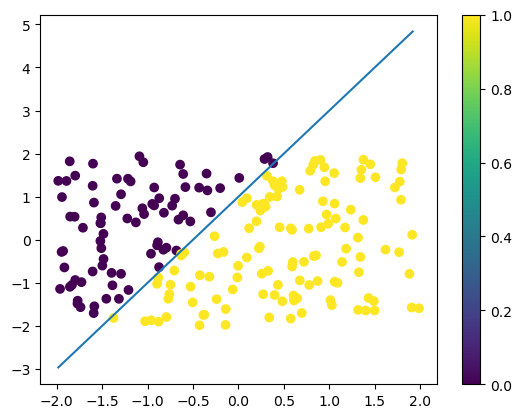

In [65]:
v = np.arange(x[:,0].min(),x[:,0].max(),0.1)
plt.scatter(x[:,0],x[:,1],c=y[:])
plt.plot(v,a*v+b)
plt.colorbar()

In [66]:
mu, sigma = 0,1
x[:,1] = x[:,1] + np.random.normal(loc=mu, scale=sigma, size=nsamples)

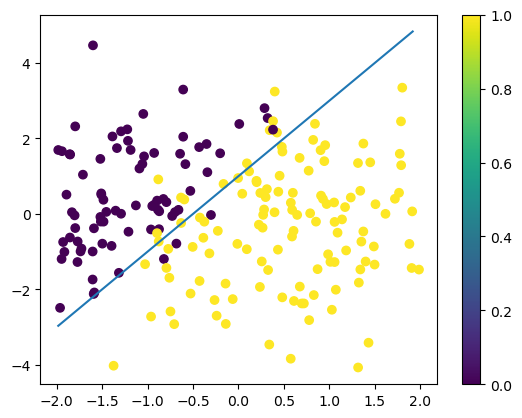

In [67]:
v = np.arange(x[:,0].min(),x[:,0].max(),0.1)
plt.scatter(x[:,0],x[:,1],c=y[:])
plt.plot(v,a*v+b)
plt.colorbar()